# Exploration of External Memory in Variational Auto-Encoder in  PyTorch

## Introduction to VQ-VAE

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation.

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

### Code

The original vq-vae pytorch can be found at [vq-vae](https://github.com/zalandoresearch/pytorch-vq-vae)


## Basic Idea

The overall architecture is summarized in the diagram below:

![](https://github.com/YuhuiNi/Exploration-of-External-Memory-in-Variational-Auto-Encoder/raw/master/images/vq-vae.png)

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector $e_i$.

The model will take in batches of RGB images, of size 32x32 for our example, and pass it through a ConvNet encoder producing some output, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index. 

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed image. 

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is composed of three components:

1. reconstruction loss which optimizes the decoder and encoder
1. due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. also since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [0]:
#!pip3 install -U -r requirements.txt

In [0]:
!pip install umap
!pip install torch
!pip install torchvision

In [0]:
from __future__ import print_function

import os
import subprocess
import tempfile

from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [0]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                  ]))

Files already downloaded and verified
Files already downloaded and verified


In [0]:
data_variance = np.var(training_data.train_data / 255.0)

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [0]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

This is different from original implement. Here we implement our external memory mechanism.

In [0]:
class NeuralTuringMemo(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(NeuralTuringMemo, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
        
        
        distances=F.softmax(distances,dim=1)
        
        #get output
        output=torch.matmul(distances,self._embedding.weight).view(input_shape)
        
        # convert quantized from BHWC -> BCHW
        return output.permute(0, 3, 1, 2).contiguous()

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [0]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList(
            [Residual(in_channels, num_hiddens, num_residual_hiddens)] * self._num_residual_layers)
        
    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [0]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        
        return self._residual_stack(x)

In [0]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        x=self._conv_trans_2(x)
        
        return F.sigmoid(x)

## Train

We use the hyperparameters from the author's code:

In [0]:
batch_size = 32
num_training_updates = 25000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 3e-4

In [0]:
training_loader = DataLoader(training_data, 
                             batch_size=batch_size, 
                             shuffle=True,
                             pin_memory=True)

In [0]:
validation_loader = DataLoader(validation_data,
                               batch_size=batch_size,
                               shuffle=True,
                               pin_memory=True)

This is our new model.

In [0]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        self._neural_turing_memo=NeuralTuringMemo(num_embeddings, embedding_dim)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        quantized= self._neural_turing_memo(z)
        x_recon = self._decoder(quantized)

        return x_recon

This is the original model

In [0]:
class OldModel(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(OldModel, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [0]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

In [0]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    data_recon=model(data)
    recon_error = torch.mean((data_recon - data)**2) / data_variance
    loss = recon_error
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    #train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        #print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 0.636

200 iterations
recon_error: 0.315

300 iterations
recon_error: 0.243

400 iterations
recon_error: 0.227

500 iterations
recon_error: 0.213

600 iterations
recon_error: 0.209

700 iterations
recon_error: 0.205

800 iterations
recon_error: 0.202

900 iterations
recon_error: 0.200

1000 iterations
recon_error: 0.198

1100 iterations
recon_error: 0.181

1200 iterations
recon_error: 0.158

1300 iterations
recon_error: 0.147

1400 iterations
recon_error: 0.139

1500 iterations
recon_error: 0.131

1600 iterations
recon_error: 0.121

1700 iterations
recon_error: 0.117

1800 iterations
recon_error: 0.111

1900 iterations
recon_error: 0.110

2000 iterations
recon_error: 0.103

2100 iterations
recon_error: 0.104

2200 iterations
recon_error: 0.102

2300 iterations
recon_error: 0.103

2400 iterations
recon_error: 0.098

2500 iterations
recon_error: 0.097

2600 iterations
recon_error: 0.098

2700 iterations
recon_error: 0.096

2800 iterations
recon_error: 0.096

2

In [0]:
oldmodel = OldModel(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [0]:
optimizer = optim.Adam(oldmodel.parameters(), lr=learning_rate, amsgrad=True)

In [0]:
oldmodel.train()
old_train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = oldmodel(data)
    recon_error = torch.mean((data_recon - data)**2) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    old_train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(old_train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 0.986
perplexity: 1.000

200 iterations
recon_error: 0.993
perplexity: 1.000

300 iterations
recon_error: 0.969
perplexity: 1.000

400 iterations
recon_error: 0.978
perplexity: 1.000

500 iterations
recon_error: 0.969
perplexity: 1.000

600 iterations
recon_error: 0.695
perplexity: 1.932

700 iterations
recon_error: 0.389
perplexity: 2.672

800 iterations
recon_error: 0.288
perplexity: 4.258

900 iterations
recon_error: 0.244
perplexity: 7.295

1000 iterations
recon_error: 0.207
perplexity: 12.512

1100 iterations
recon_error: 0.185
perplexity: 16.588

1200 iterations
recon_error: 0.173
perplexity: 19.062

1300 iterations
recon_error: 0.167
perplexity: 21.055

1400 iterations
recon_error: 0.163
perplexity: 22.772

1500 iterations
recon_error: 0.158
perplexity: 23.546

1600 iterations
recon_error: 0.156
perplexity: 25.387

1700 iterations
recon_error: 0.156
perplexity: 27.007

1800 iterations
recon_error: 0.149
perplexity: 28.728

1900 iterations
recon_error:

## Plot Loss

In [0]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)

Text(0.5,0,u'iteration')

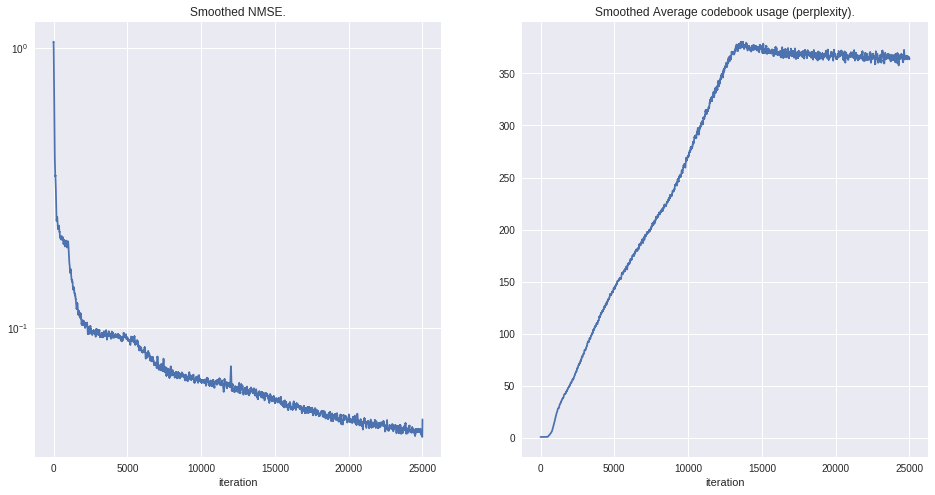

In [0]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [0]:
model.eval()
oldmodel.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
valid_quantize= model._neural_turing_memo(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

old_vq_output_eval = oldmodel._pre_vq_conv(oldmodel._encoder(valid_originals))
_, old_valid_quantize, _, _ = oldmodel._vq_vae(old_vq_output_eval)
old_valid_reconstructions = oldmodel._decoder(old_valid_quantize)

In [0]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
train_reconstructions= model._neural_turing_memo(train_originals)

In [0]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

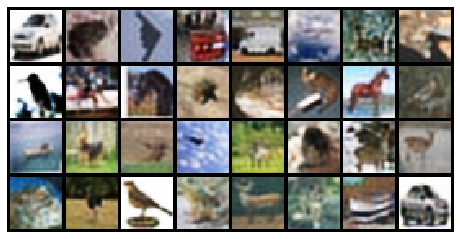

In [0]:
show(make_grid(valid_reconstructions.cpu().data))

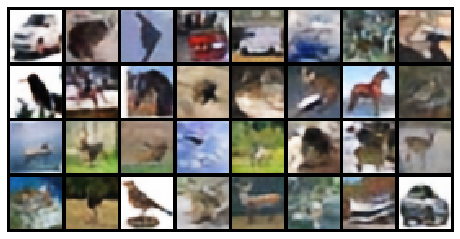

In [0]:
show(make_grid(old_valid_reconstructions.cpu().data))

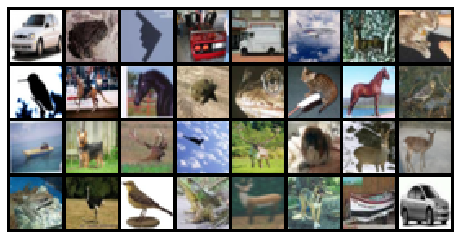

In [0]:
show(make_grid(valid_originals.cpu()))